In [1]:
import timeit
import tqdm
import pprint
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'

In [3]:
import pyquaternion
import quaternion
import rowan

/home/vramasub/.local/lib/python3.6/site-packages/quaternion/numba_wrapper.py:29: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from either numbapro or numba.
This means that the code will run MUCH more slowly.
You probably REALLY want to install numba / numbapro.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [4]:
def arr_to_pyquat(arr):
    if len(arr.shape) > 1:
        pq_arr = np.empty(arr.shape[:-1], dtype='object')
        for i in range(len(arr)):
            pq_arr[i] = pyquaternion.Quaternion(arr[i])
    else:
        pq_arr = np.array([pyquaternion.Quaternion(arr)])
    return pq_arr

def arr_to_npquat(arr):
    return quaternion.as_quat_array(arr)

pyquat_times = {}
quat_times = {}
rowan_times = {}
#max_log_N = 7
#Ns = [10**i for i in range(max_log_N)]
Ns = [10, 100000]
num = 10
pqlim = 1e8

In [5]:
pyquat_times['Multiply'] = []
quat_times['Multiply'] = []
rowan_times['Multiply'] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)
    y = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times['Multiply'].append(
            timeit.timeit(
                "x*y",
                setup="from __main__ import x, y, arr_to_pyquat; x = arr_to_pyquat(x); y = arr_to_pyquat(y)",
                number = num
            )
        )
    quat_times['Multiply'].append(
        timeit.timeit(
            "x*y",
            setup="from __main__ import x, y, arr_to_npquat; x = arr_to_npquat(x); y = arr_to_npquat(y)",
            number = num
        )
    )
    rowan_times['Multiply'].append(
        timeit.timeit(
            "rowan.multiply(x, y)",
            setup="from __main__ import x, y, rowan",
            number = num
        )
    )

In [6]:
pyquat_times['Exponential'] = []
quat_times['Exponential'] = []
rowan_times['Exponential'] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times['Exponential'].append(
            timeit.timeit(
                "for i in range(len(x)): pyquaternion.Quaternion.exp(x[i])",
                setup="from __main__ import x, pyquaternion, arr_to_pyquat; x = arr_to_pyquat(x);",
                number = num
            )
        )
    quat_times['Exponential'].append(
        timeit.timeit(
            "np.exp(x)",
            setup="from __main__ import x, arr_to_npquat, np; x = arr_to_npquat(x);",
            number = num
        )
    )
    rowan_times['Exponential'].append(
        timeit.timeit(
            "rowan.exp(x)",
            setup="from __main__ import x, rowan",
            number = num
        )
    )

In [7]:
pyquat_times['Conjugate'] = []
quat_times['Conjugate'] = []
rowan_times['Conjugate'] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times['Conjugate'].append(
            timeit.timeit(
                "for i in range(len(x)): x.conjugate",
                setup="from __main__ import x, arr_to_pyquat; x = arr_to_pyquat(x);",
                number = num
            )
        )
    quat_times['Conjugate'].append(
        timeit.timeit(
            "x.conjugate()",
            setup="from __main__ import x, arr_to_npquat; x = arr_to_npquat(x);",
            number = num
        )
    )
    rowan_times['Conjugate'].append(
        timeit.timeit(
            "rowan.conjugate(x)",
            setup="from __main__ import x, rowan",
            number = num
        )
    )

In [8]:
pyquat_times['Norm'] = []
quat_times['Norm'] = []
rowan_times['Norm'] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times['Norm'].append(
            timeit.timeit(
                "for i in range(len(x)): x[i].norm",
                setup="from __main__ import x, arr_to_pyquat; x = arr_to_pyquat(x);",
                number = num
            )
        )
    quat_times['Norm'].append(
        timeit.timeit(
            "np.abs(x)",
            setup="from __main__ import x, np, arr_to_npquat; x = arr_to_npquat(x);",
            number = num
        )
    )
    rowan_times['Norm'].append(
        timeit.timeit(
            "rowan.norm(x)",
            setup="from __main__ import x, rowan",
            number = num
        )
    )

In [9]:
pyquat_times['To Matrix'] = []
quat_times['To Matrix'] = []
rowan_times['To Matrix'] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times['To Matrix'].append(
            timeit.timeit(
                "for i in range(len(x)): x[i].rotation_matrix",
                setup="from __main__ import x, arr_to_pyquat; x = arr_to_pyquat(x);",
                number = num
            )
        )
    quat_times['To Matrix'].append(
        timeit.timeit(
            "quaternion.as_rotation_matrix(x)",
            setup="from __main__ import x, quaternion, arr_to_npquat; x = arr_to_npquat(x);",
            number = num
        )
    )
    rowan_times['To Matrix'].append(
        timeit.timeit(
            "rowan.to_matrix(x)",
            setup="from __main__ import x, rowan",
            number = num
        )
    )

In [10]:
pyquat_times['N'] = list(np.array(Ns)[np.array(Ns) < pqlim])
quat_times['N'] = Ns
rowan_times['N'] = Ns

In [11]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(pyquat_times)
pp.pprint(quat_times)
pp.pprint(rowan_times)

{   'Conjugate': [8.697854354977608e-06, 0.049719461938366294],
    'Exponential': [0.004738935036584735, 36.29777322104201],
    'Multiply': [0.0023011979646980762, 18.41943288478069],
    'N': [10, 100000],
    'Norm': [0.0003978859167546034, 1.1691303220577538],
    'To Matrix': [0.002479007001966238, 16.60043488908559]}
{   'Conjugate': [2.7660978958010674e-05, 0.0026233699172735214],
    'Exponential': [2.6322901248931885e-05, 0.06091928598470986],
    'Multiply': [1.7660902813076973e-05, 0.006287420867010951],
    'N': [10, 100000],
    'Norm': [1.0211020708084106e-05, 0.0030802348628640175],
    'To Matrix': [0.001374115003272891, 0.0862035898026079]}
{   'Conjugate': [0.00021101091988384724, 0.014803183963522315],
    'Exponential': [0.0016991300508379936, 0.14439566410146654],
    'Multiply': [0.0012474891263991594, 0.07363750506192446],
    'N': [10, 100000],
    'Norm': [0.00015798211097717285, 0.017006403068080544],
    'To Matrix': [0.0018621261697262526, 0.086559572024270

In [12]:
df_pq = pd.DataFrame(pyquat_times).melt(id_vars="N", var_name="operation", value_name="pyquaternion")
df_nq = pd.DataFrame(quat_times).melt(id_vars="N", var_name="operation", value_name="npquaternion")
df_r = pd.DataFrame(rowan_times).melt(id_vars="N", var_name="operation", value_name="rowan")
df = df_r.merge(df_nq, on =["N", "operation"])
df = df.merge(df_pq, on =["N", "operation"], how = "left")
df.fillna(0, inplace=True)
df['pyquaternion'] /= df['N']
df['pyquaternion'] *= 1e6
df['npquaternion'] /= df['N']
df['npquaternion'] *= 1e6
df['rowan'] /= df['N']
df['rowan'] *= 1e6

In [13]:
df[(df['N'] == 100000)].drop('pyquaternion', axis=1)
view = df.groupby(["N", "operation"]).mean()
view['rowan vs. npq'] = view['rowan']/view['npquaternion']
view['pyq vs. rowan'] = view['pyquaternion']/view['rowan']
view

rowan  npquaternion  pyquaternion  rowan vs. npq  \
N      operation                                                            
10     Conjugate     21.101092      2.766098      0.869785       7.628469   
       Exponential  169.913005      2.632290    473.893504      64.549498   
       Multiply     124.748913      1.766090    230.119796      70.635637   
       Norm          15.798211      1.021102     39.788592      15.471726   
       To Matrix    186.212617    137.411500    247.900700       1.355146   
100000 Conjugate      0.148032      0.026234      0.497195       5.642812   
       Exponential    1.443957      0.609193    362.977732       2.370278   
       Multiply       0.736375      0.062874    184.194329      11.711878   
       Norm           0.170064      0.030802     11.691303       5.521138   
       To Matrix      0.865596      0.862036    166.004349       1.004130   

                    pyq vs. rowan  
N      operation                   
10     Conjugate         0.041220  
       Exponential       2.789036  
       Multiply          1.844664  
       Norm              2.518550  
       To Matrix         1.331278  
100000 Conjugate         3.358701  
       Exponential     251.377169  
       Multiply        250.136569  
       Norm             68.746478  
       To Matrix       191.780464

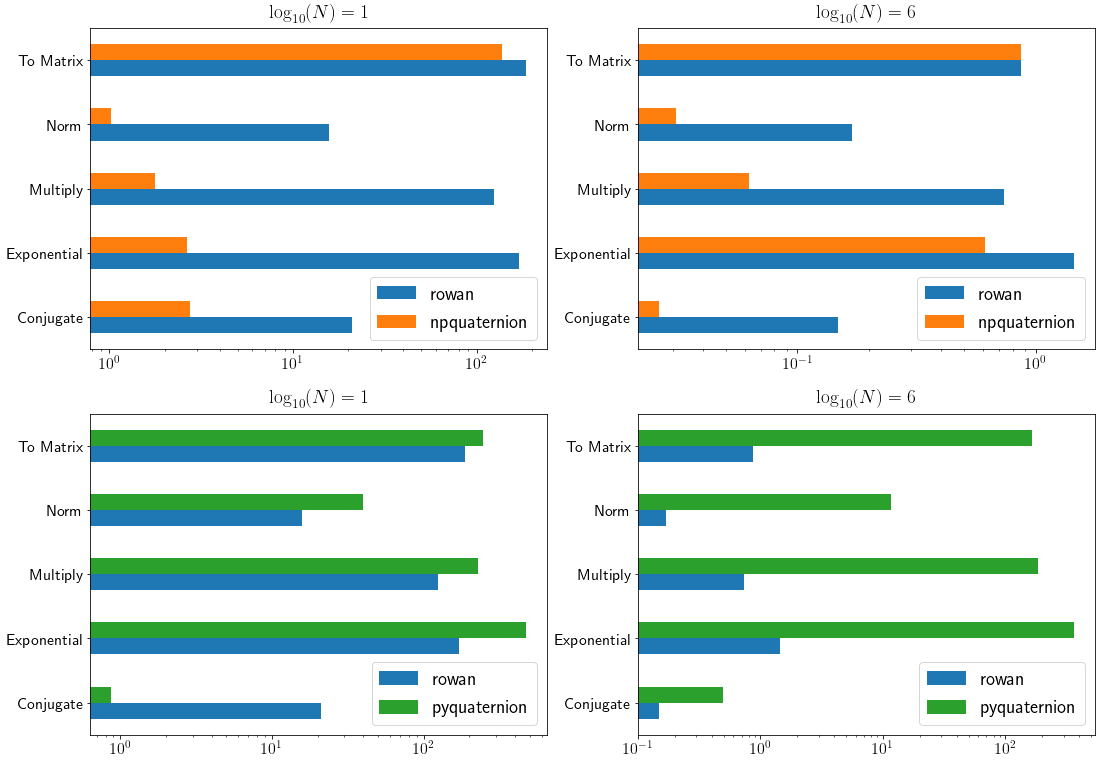

In [14]:
cols = list(col['color'] for col in plt.rcParams['axes.prop_cycle'])
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
df[df['N'] == 10].drop(['N', 'pyquaternion'], axis=1).groupby(
    ["operation"]).mean().plot.barh(ax=axes[0, 0], logx=True, color = cols[0:2], title="$\log_{10}(N) = 1$")
df[df['N'] == 100000].drop(['N', 'pyquaternion'], axis=1).groupby(
    ["operation"]).mean().plot.barh(ax=axes[0, 1], logx=True, color = cols[0:2], title="$\log_{10}(N) = 6$")
df[df['N'] == 10].drop(['N', 'npquaternion'], axis=1).groupby(
    ["operation"]).mean().plot.barh(ax=axes[1, 0], logx=True, color = cols[0:4:2], title="$\log_{10}(N) = 1$")
df[df['N'] == 100000].drop(['N', 'npquaternion'], axis=1).groupby(
    ["operation"]).mean().plot.barh(ax=axes[1, 1], logx=True, color = cols[0:4:2], title="$\log_{10}(N) = 6$")
for ax in axes.flatten():
    ax.set_ylabel("")
    ax.set_label
plt.show()
fig.savefig("Performance.png")